In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl
# %matplotlib qt
import sys
sys.path.append('C:\code\qdc2')
import matplotlib.pyplot as plt 
import os 
import numpy as np 
from qdc.mmf.many_wl_fiber import ManyWavelengthFiber
from qdc.mmf.qdc_mmf_experiment import QDCMMFExperiment
from qdc.misc import tnow
DATA_DIR = os.path.join(os.path.abspath(os.path.join(os.path.curdir, '..', 'data')))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Main results & dz dependence 

In [71]:
def run_mmf(is_step_index=False, only_z0=False):
    fiber_L = 0.1e6  if is_step_index else 3e6 # um 
    N_wl = 81
    # waist_sizes = [0.45, 0.6, 0.75]
    waist_sizes = [0.6]
    N_positions = 23 
    N_classical = N_positions * len(waist_sizes)
    N_SPDC = N_positions * len(waist_sizes)
    wl0 = 0.810
    Dwl = 0.040 if is_step_index else 0.040
    NA_ref = 0.2   
    dzs = [0, 10, 50, 150, 400] if is_step_index else [0, 10, 30, 50, 250]
    if only_z0:
        dzs = [0]
    npoints = 2**8
    free_mode_matrix = False if npoints == 2**7 else True  # when working with 2**8, the RAM explodes 
    free_mode_matrix = True
    autosolve = not free_mode_matrix  # if freeing each time - no point in autosolving initially 

    
    n_pixels_diameter = npoints//4 if is_step_index else npoints//4
    s = ManyWavelengthFiber(wl0=wl0, Dwl=Dwl, N_wl=N_wl, fiber_L=fiber_L, rng_seed=123, is_step_index=is_step_index, 
                            npoints=npoints, NA_ref=NA_ref, autosolve=autosolve)
    
    g_params_list = []
    if N_classical == 1:
        g_params_list = [np.array([0.7, 8, 0, 0.0, 0.0])]
    else:
        for waist in waist_sizes:
            # Generate N_positions for each waist size
            positions = np.linspace(0, 22, N_positions)
            for Dx in positions:
                g_params_list.append(np.array([waist, Dx, 0, 0.0, 0.0]))
    
    exp = QDCMMFExperiment(s, free_mode_matrix=free_mode_matrix)
    exp._set_PCC_slice(n_pixels_diameter=n_pixels_diameter)
    res = exp.run_PCCs_different_dz(dzs=dzs, N_classical=N_classical, N_SPDC=N_SPDC, g_params_list=g_params_list)

    f_type = 'SI' if is_step_index else 'GRIN'
    if exp.excite_modes is not None:
        saveto_path = rf'{DATA_DIR}\\{tnow()}_{f_type}_{round(fiber_L*1e-6, 2)}m_N={N_SPDC}_excite_modes={exp.excite_modes}.npz'
    else:
        saveto_path = rf'{DATA_DIR}\\{tnow()}_{f_type}_{round(fiber_L*1e-6, 2)}m_N={N_SPDC}_Dwl={Dwl}.npz'
    res.saveto(saveto_path)
    return res

res_SI = run_mmf(is_step_index=True, only_z0=True)
res_GRIN = run_mmf(is_step_index=False, only_z0=True)

Getting 81 fibers...


81it [00:01, 63.20it/s]


Got fibers!
No modes found, not populating mega-beta matrix
Getting classical with average on 23 ...


Running classical measurements:   0%|          | 0/23 [00:00<?, ?it/s]C:\Users\owner\AppData\Roaming\Python\Python310\site-packages\pyMMF\solvers\SI.py:147: RuntimeWarning: invalid value encountered in double_scalars
  return jv(m, u) / (u * jv(m - 1, u)) + kn(m, w) / (w * kn(m - 1, w))
C:\Users\owner\AppData\Roaming\Python\Python310\site-packages\pyMMF\solvers\SI.py:147: RuntimeWarning: invalid value encountered in divide
  return jv(m, u) / (u * jv(m - 1, u)) + kn(m, w) / (w * kn(m - 1, w))
Running classical measurements: 100%|██████████| 23/23 [1:06:06<00:00, 172.44s/it]


Getting SPDC with average on 23, dz=0 ...


Running SPDC measurements: 100%|██████████| 23/23 [1:49:38<00:00, 286.01s/it]


Getting 81 fibers...


81it [00:04, 19.42it/s]


Got fibers!
No modes found, not populating mega-beta matrix
Getting classical with average on 23 ...


Running classical measurements: 100%|██████████| 23/23 [32:05<00:00, 83.72s/it]  


Getting SPDC with average on 23, dz=0 ...


Running SPDC measurements: 100%|██████████| 23/23 [1:02:47<00:00, 163.79s/it]


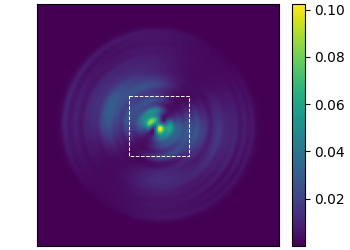

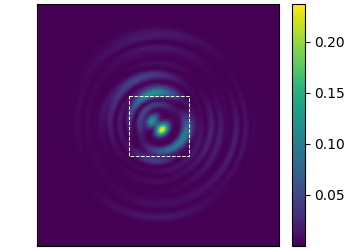

In [36]:
res_SI.show_incoherent_sums(iter_no=8, dz=0, saveto_path=None)

## View results 

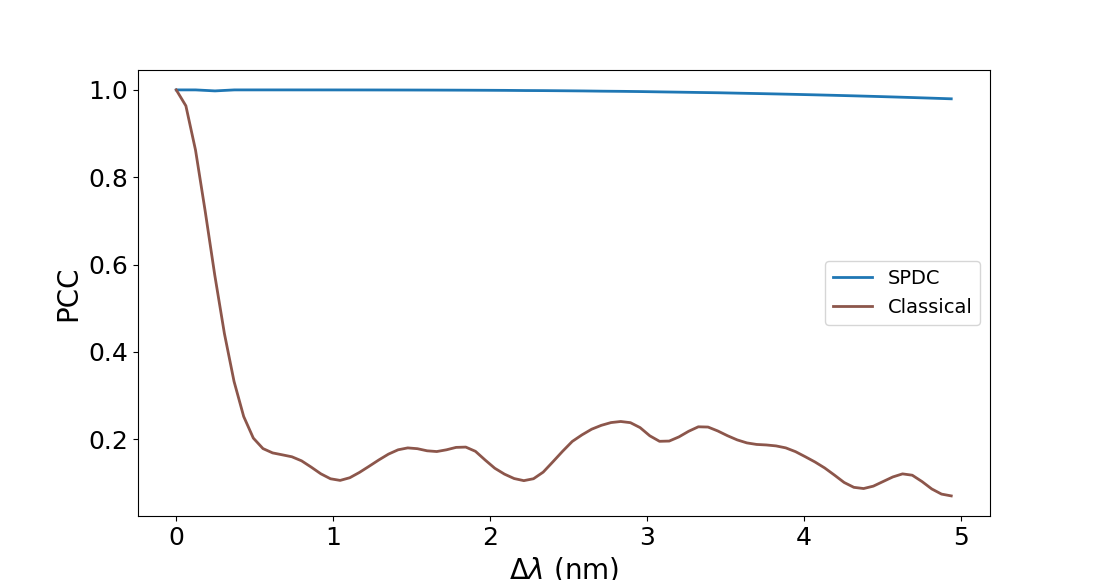

In [32]:
from qdc.mmf.qdc_mmf_result import QDCMMFResult
fiber_type = 'SI'
fig2_path = r"G:\My Drive\Projects\Dispersion Cancelation\Paper\Data\2025_09_16_01_56_49_SI_0.1m_N=23_paper.npz"
res = QDCMMFResult()
res.loadfrom(fig2_path)
saveto_path = fr'G:\My Drive\Projects\Dispersion Cancelation\Paper\Partial Figures\PCCs_{fiber_type}.png'
res.show_PCCs(title='', show0=True, saveto_path=saveto_path)

In [ ]:
is_step_index = True
res = res_SI if is_step_index else res_GRIN
fiber_type = 'SI' if is_step_index else 'GRIN'

print(f'fiber_type: {fiber_type}')

# Main text 
saveto_path = fr'G:\My Drive\Projects\Dispersion Cancelation\Paper\Partial Figures\PCCs_{fiber_type}.png'
saveto_path = None
res.show_PCCs(title='', iter_no=49, show0=True, saveto_path=saveto_path)

saveto_path = fr'G:\My Drive\Projects\Dispersion Cancelation\Paper\Partial Figures\incoherent_sum_{fiber_type}.png'
saveto_path = None
res.show_incoherent_sums(iter_no=16, dz=0, saveto_path=saveto_path)

# Combine these and the setup in pptx for final figure for main text 

# SI 
saveto_path = fr'G:\My Drive\Projects\Dispersion Cancelation\Paper\Final Figures\PCCs_dzs_{fiber_type}.png'
saveto_path = None
res.show_PCCs(title='', iter_no=None, show0=False, saveto_path=saveto_path)


NameError: name 'res_SI' is not defined

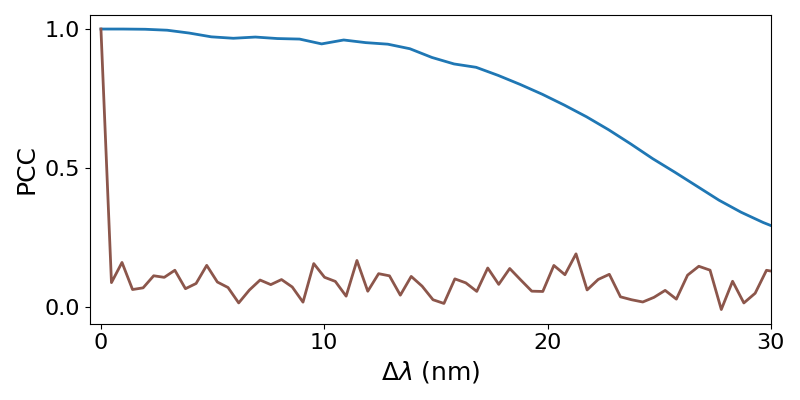

In [17]:
import sys
sys.path.append('C:\code\qdc2')
from qdc.mmf.qdc_mmf_result import QDCMMFResult
%autoreload 2

SI_path = r'C:\code\qdc2\qdc\data\2025_09_28_19_30_08_SI_0.1m_N=23_Dwl=0.04.npz'
# SI_path = r'C:\code\qdc2\qdc\data\2025_09_28_13_22_35_SI_0.1m_N=23_Dwl=0.08.npz'
# GRIN_path = r'C:\code\qdc2\qdc\data\2025_09_28_21_05_05_GRIN_3.0m_N=23_Dwl=0.04.npz'
# GRIN_path = r'C:\code\qdc2\qdc\data\2025_09_28_14_52_27_GRIN_3.0m_N=23_Dwl=0.08.npz'
path = SI_path

res = QDCMMFResult()
res.loadfrom(path)
# res.show_PCCs(title='', iter_no=None, show0=True)
saveto_path = None
saveto_path = r'G:\My Drive\Projects\Dispersion Cancelation\Paper\Partial Figures\PCCs_inset.png'
# res.show_incoherent_sums(iter_no=8, show_square=False, saveto_path=saveto_path, colorbar=False)
res.show_PCCs(title='', iter_no=None, show0=False, saveto_path=saveto_path, xlim=(-0.5, 30))
plt.show(block=False)

In [ ]:
# res = res_GRIN
res = res_SI
for i in range(5):
    # res.show_incoherent_sum(iter_no=i, dz=0)
    res.show_PCCs(title='', iter_no=i, show0=False)
    print(res.metadata["g_params_list"][i])

# Phase matching dependence

In [59]:
def run_phase_matching(is_step_index=False, Lc_um=2000, only_SPDC=False):
    fiber_L = 0.1e6  if is_step_index else 3e6 # um 
    N_wl = 81
    N_positions = 23 
    N_classical = N_positions
    N_SPDC = N_positions 
    wl0 = 0.810
    Dwl = 0.005 if is_step_index else 0.015
    NA_ref = 0.2   

    dzs = [0]
    npoints = 2**8
    free_mode_matrix = False if npoints == 2**7 else True  # when working with 2**8, the RAM explodes 
    free_mode_matrix = True
    autosolve = not free_mode_matrix  # if freeing each time - no point in autosolving initially 
    
    n_pixels_diameter = npoints//4 if is_step_index else npoints//4
    s = ManyWavelengthFiber(wl0=wl0, Dwl=Dwl, N_wl=N_wl, fiber_L=fiber_L, rng_seed=123, is_step_index=is_step_index, 
                            npoints=npoints, NA_ref=NA_ref, autosolve=autosolve)
    
    if N_classical == 1:
        g_params_list = [np.array([0.7, 8, 0, 0.0, 0.0])]
    else:   
        positions = np.linspace(0, 22, N_positions)
        g_params_list = [np.array([0.6, Dx, 0, 0.0, 0.0]) for Dx in positions]
    
    exp = QDCMMFExperiment(s, free_mode_matrix=free_mode_matrix)
    exp._set_PCC_slice(n_pixels_diameter=n_pixels_diameter)
    exp.set_phase_matching(Lc_um=Lc_um, pump_waist_crystal=500, magnification=10)
    if only_SPDC:
        N_classical = 1
    res = exp.run_PCCs_different_dz(dzs=dzs, N_classical=N_classical, N_SPDC=N_SPDC, g_params_list=g_params_list)

    f_type = 'SI' if is_step_index else 'GRIN'
    saveto_path = rf'{DATA_DIR}\\{tnow()}_{f_type}_{round(fiber_L*1e-6, 2)}m_N=100.npz'
    res.saveto(saveto_path)
    return res

ress_SI = []
ress_GRIN = []

# Classical result does not depend on phase matching 
ress_SI.append(run_phase_matching(is_step_index=True, Lc_um=1000))
ress_GRIN.append(run_phase_matching(is_step_index=False, Lc_um=1000))

Lcs = [2000, 4000, 8000, 16000]
for Lc in Lcs:
    ress_SI.append(run_phase_matching(is_step_index=True, Lc_um=Lc, only_SPDC=True))
    ress_GRIN.append(run_phase_matching(is_step_index=False, Lc_um=Lc, only_SPDC=True))

Getting 81 fibers...


81it [00:01, 63.02it/s]


Got fibers!
No modes found, not populating mega-beta matrix
Getting classical with average on 23 ...


Running classical measurements: 100%|██████████| 23/23 [1:00:42<00:00, 158.37s/it]


Getting SPDC with average on 23, dz=0 ...


Running SPDC measurements: 100%|██████████| 23/23 [2:07:13<00:00, 331.90s/it]  


Getting 81 fibers...


81it [00:04, 18.93it/s]


Got fibers!
No modes found, not populating mega-beta matrix
Getting classical with average on 23 ...


Running classical measurements: 100%|██████████| 23/23 [32:39<00:00, 85.19s/it]


Getting SPDC with average on 23, dz=0 ...


Running SPDC measurements: 100%|██████████| 23/23 [55:23<00:00, 144.52s/it] 


Getting 81 fibers...


81it [00:01, 64.56it/s]


Got fibers!
No modes found, not populating mega-beta matrix
Getting classical with average on 1 ...


Running classical measurements: 100%|██████████| 1/1 [02:24<00:00, 144.82s/it]


Getting SPDC with average on 23, dz=0 ...


Running SPDC measurements: 100%|██████████| 23/23 [1:49:17<00:00, 285.12s/it]


Getting 81 fibers...


81it [00:04, 19.69it/s]


Got fibers!
No modes found, not populating mega-beta matrix
Getting classical with average on 1 ...


Running classical measurements: 100%|██████████| 1/1 [01:16<00:00, 76.18s/it]


Getting SPDC with average on 23, dz=0 ...


Running SPDC measurements: 100%|██████████| 23/23 [55:01<00:00, 143.54s/it]


Getting 81 fibers...


81it [00:01, 66.30it/s]


Got fibers!
No modes found, not populating mega-beta matrix
Getting classical with average on 1 ...


Running classical measurements: 100%|██████████| 1/1 [02:25<00:00, 145.81s/it]


Getting SPDC with average on 23, dz=0 ...


Running SPDC measurements: 100%|██████████| 23/23 [1:49:41<00:00, 286.13s/it]


Getting 81 fibers...


81it [00:04, 19.69it/s]


Got fibers!
No modes found, not populating mega-beta matrix
Getting classical with average on 1 ...


Running classical measurements: 100%|██████████| 1/1 [01:16<00:00, 76.63s/it]


Getting SPDC with average on 23, dz=0 ...


Running SPDC measurements: 100%|██████████| 23/23 [55:51<00:00, 145.72s/it]


Getting 81 fibers...


81it [00:01, 65.16it/s]


Got fibers!
No modes found, not populating mega-beta matrix
Getting classical with average on 1 ...


Running classical measurements: 100%|██████████| 1/1 [02:23<00:00, 143.26s/it]


Getting SPDC with average on 23, dz=0 ...


Running SPDC measurements: 100%|██████████| 23/23 [1:48:53<00:00, 284.08s/it]


Getting 81 fibers...


81it [00:04, 19.72it/s]


Got fibers!
No modes found, not populating mega-beta matrix
Getting classical with average on 1 ...


Running classical measurements: 100%|██████████| 1/1 [01:16<00:00, 76.46s/it]


Getting SPDC with average on 23, dz=0 ...


Running SPDC measurements: 100%|██████████| 23/23 [55:03<00:00, 143.64s/it]


Getting 81 fibers...


81it [00:01, 65.41it/s]


Got fibers!
No modes found, not populating mega-beta matrix
Getting classical with average on 1 ...


Running classical measurements: 100%|██████████| 1/1 [02:24<00:00, 144.17s/it]


Getting SPDC with average on 23, dz=0 ...


Running SPDC measurements: 100%|██████████| 23/23 [1:52:25<00:00, 293.28s/it]


Getting 81 fibers...


81it [00:04, 19.78it/s]


Got fibers!
No modes found, not populating mega-beta matrix
Getting classical with average on 1 ...


Running classical measurements: 100%|██████████| 1/1 [01:18<00:00, 78.68s/it]


Getting SPDC with average on 23, dz=0 ...


Running SPDC measurements: 100%|██████████| 23/23 [55:53<00:00, 145.82s/it]


## View results 

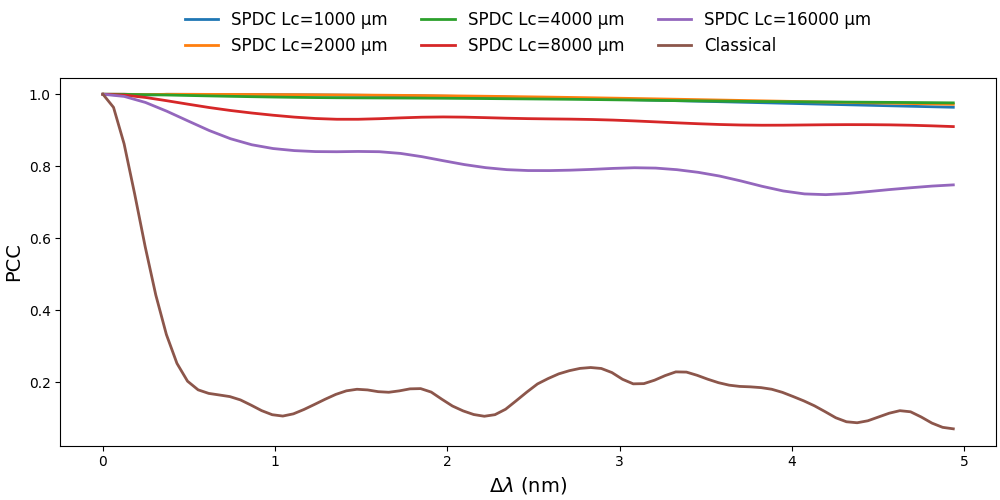

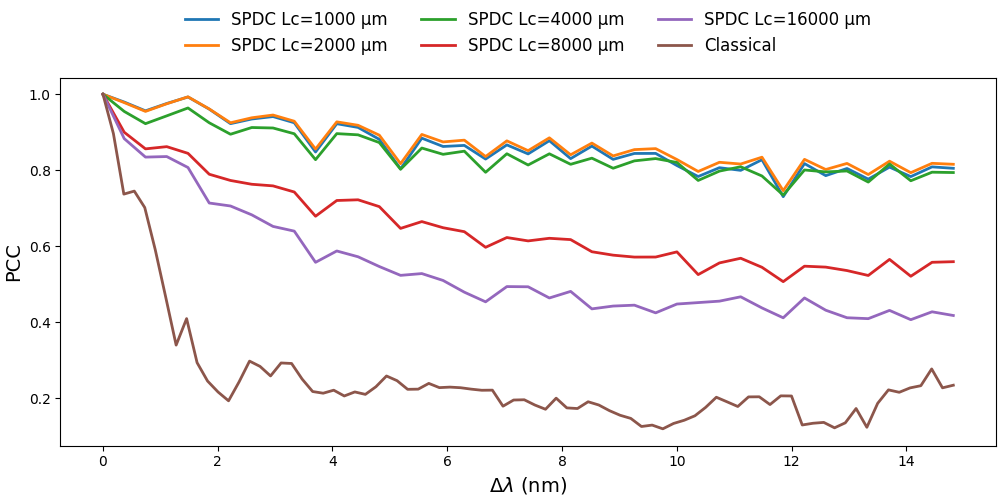

In [60]:
def show_classical_and_spdc_phase_matching(results, L_cs, iter_no=None, saveto_path=None):
    fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)

    # Plot SPDC from all results
    for i, res in enumerate(results):
        for dz_key, (dl, _) in res.SPDC_by_dz.items():
            if iter_no is None:
                y_spdc = res.SPDC_pccs_average(dz_key)
                label_spdc = f"SPDC Lc={L_cs[i]} μm"
            else:
                y_spdc = res.SPDC_pccs_all_by_dz[dz_key][iter_no]
                label_spdc = f"SPDC Lc={L_cs[i]} μm iter {iter_no}"
            ax.plot(dl * 1e3, y_spdc, '-', label=label_spdc, linewidth=2)

    res0 = results[0]
    if iter_no is None:
        y_classical = res0.classical_pccs_average
        label_classical = f"Classical"
    else:
        y_classical = res0.classical_pccs_all[iter_no]
        label_classical = f"Classical iter {iter_no}"
    ax.plot(res0.delta_lambdas_classical * 1e3, y_classical, '-', label=label_classical, linewidth=2, color='#8c564b')

    ax.set_xlabel(r"$\Delta \lambda$ (nm)", fontsize=14)
    ax.set_ylabel("PCC", fontsize=14)
    ax.legend(fontsize=12, loc='lower center', bbox_to_anchor=(0.5, 1.02), ncol=3, frameon=False)

    if saveto_path is not None:
        plt.savefig(saveto_path)
    else:
        plt.show()

Lcs = [1000, 2000, 4000, 8000, 16000]
saveto_path = fr'G:\My Drive\Projects\Dispersion Cancelation\Paper\Final Figures\PCCs_Lcs_SI.png'
show_classical_and_spdc_phase_matching(ress_SI, Lcs, saveto_path=saveto_path)
saveto_path = fr'G:\My Drive\Projects\Dispersion Cancelation\Paper\Final Figures\PCCs_Lcs_GRIN.png'
show_classical_and_spdc_phase_matching(ress_GRIN, Lcs, saveto_path=saveto_path)

# Effect of wavefront shaping on mode mixing 

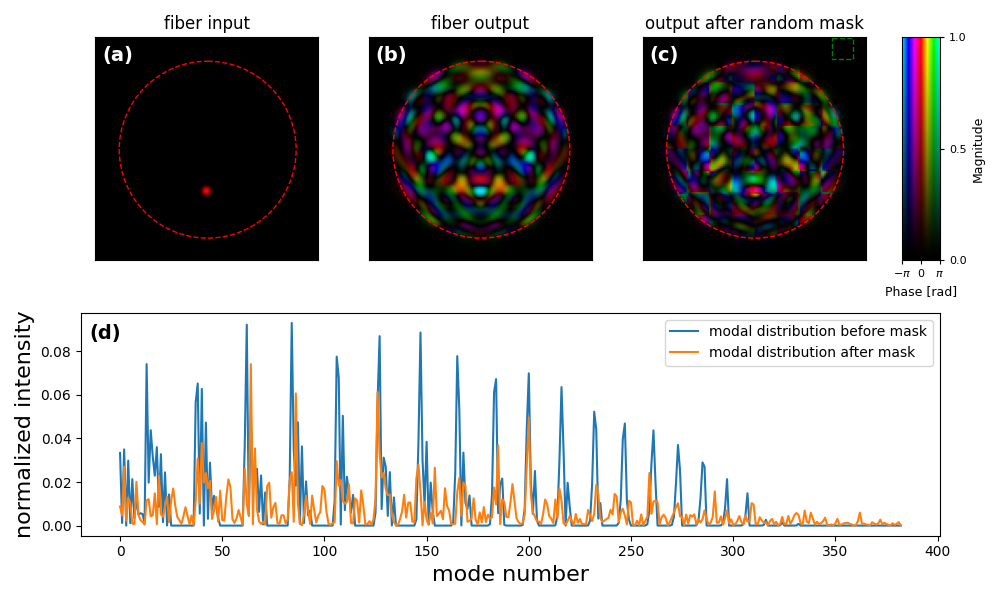

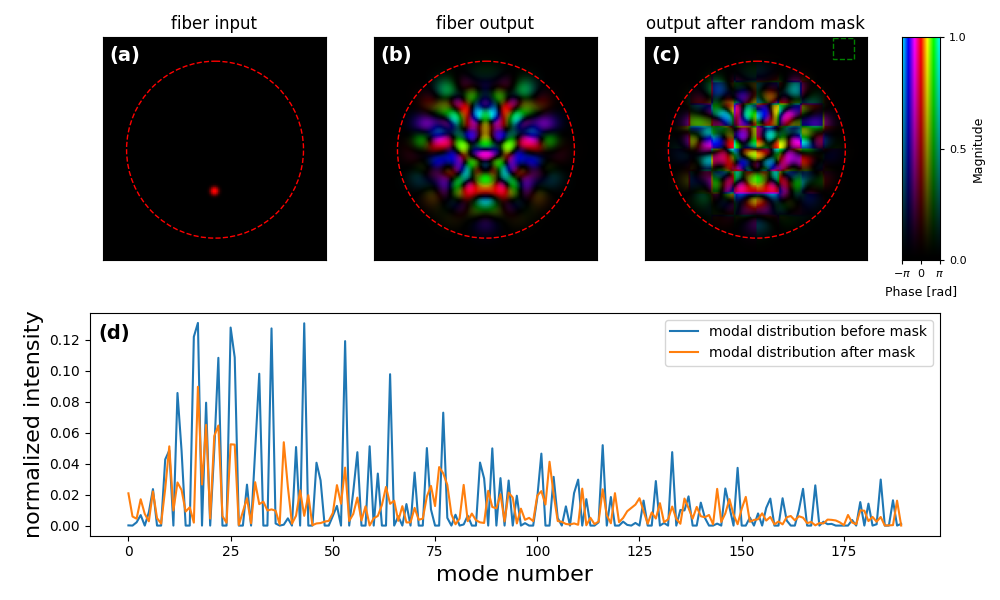

In [37]:
import cv2
from matplotlib import patches
from qdc.mmf.fiber import Fiber
from qdc.misc import show_color_legend_ax

def SLM_mixing(is_step_index, macro_pixels=10):
    f = Fiber(is_step_index=is_step_index, npoints=2**7)
    # f.set_input_gaussian(sigma=3, X0=5, Y0=10, X_linphase=0.4, Y_linphase=0.4, random_phase=0.0)
    f.set_input_gaussian(sigma=0.6, X0=12, Y0=0, X_linphase=0.0, Y_linphase=0.0, random_phase=0.0)
    f.propagate(False)

    fig, axes = plt.subplot_mosaic(
        [["left", "right", "masked", "legend"],
        ["bottom", "bottom", "bottom", "bottom"]],
        figsize=(10, 6),
        gridspec_kw={"width_ratios": [1, 1, 1, 0.15]}  
    )

    # Profile before fiber 
    f.show_profile(f.profile_0,   ax=axes["left"],   title='fiber input')
    circle = patches.Circle((f.npoints//2, f.npoints//2), 25/f.index_profile.dh, color='red', fill=False, linestyle='dashed')
    axes["left"].add_patch(circle)
    axes["left"].set_yticks([])
    axes["left"].set_xticks([])
    
    # Profile before fiber 
    f.show_profile(f.profile_end, ax=axes["right"],  title='fiber output')
    circle = patches.Circle((f.npoints//2, f.npoints//2), 25/f.index_profile.dh, color='red', fill=False, linestyle='dashed')
    axes["right"].add_patch(circle)
    axes["right"].set_yticks([])
    axes["right"].set_xticks([])

    # Profile after mask
    A = np.random.uniform(0, 2*np.pi, size=(macro_pixels, macro_pixels))
    if not isinstance(f.npoints, int):
        f.npoints = f.npoints.item()
    A = cv2.resize(A, (f.npoints, f.npoints), interpolation=cv2.INTER_AREA)
    A = np.exp(1j*A)
    profile_after_mask = f.profile_end * A.ravel()
    f.show_profile(profile_after_mask, ax=axes["masked"], title='output after random mask')
    square_size = f.npoints//macro_pixels
    square = patches.Rectangle((square_size*(macro_pixels-1),0), square_size, square_size, color='green', fill=False, linestyle='dashed')
    axes["masked"].add_patch(square)
    circle = patches.Circle((f.npoints//2, f.npoints//2), 25/f.index_profile.dh, color='red', fill=False, linestyle='dashed')
    axes["masked"].add_patch(circle)
    axes["masked"].set_yticks([])
    axes["masked"].set_xticks([])

    # Legend 
    show_color_legend_ax(axes["legend"])

    # Modal distributions
    modes_after_mask = f.modes.getModeMatrix().T @ profile_after_mask
    axes["bottom"].plot(np.abs(f.modes_0)**2, label='modal distribution before mask')
    axes["bottom"].plot(np.abs(modes_after_mask)**2, label='modal distribution after mask')
    axes["bottom"].legend()
    axes["bottom"].set_xlabel('mode number', fontsize=16)
    axes["bottom"].set_ylabel('normalized intensity', fontsize=16)

    # Panel labels
    axes["left"].text(0.03, 0.96, '(a)', color='white', fontsize=14, fontweight='bold', transform=axes["left"].transAxes, va='top', ha='left')
    axes["right"].text(0.03, 0.96, '(b)', color='white', fontsize=14, fontweight='bold', transform=axes["right"].transAxes, va='top', ha='left')
    axes["masked"].text(0.03, 0.96, '(c)', color='white', fontsize=14, fontweight='bold', transform=axes["masked"].transAxes, va='top', ha='left')
    axes["bottom"].text(0.01, 0.95, '(d)', color='black', fontsize=14, fontweight='bold', transform=axes["bottom"].transAxes, va='top', ha='left')

    plt.tight_layout()
    # Save figure 
    fiber_type = 'SI' if is_step_index else 'GRIN'
    fig.savefig(fr'G:\My Drive\Projects\Dispersion Cancelation\Paper\Final Figures\SLM_mixing_{fiber_type}.png')

macro_pixels = 10
SLM_mixing(is_step_index=True, macro_pixels=macro_pixels)
SLM_mixing(is_step_index=False, macro_pixels=macro_pixels)

# Focusing 

In [2]:
is_step_index = True 
fiber_L = 0.1e6 
N_wl = 81
wl0 = 0.810
Dwl = 0.020 
NA_ref = 0.2   
dzs = [0]
npoints = 2**8
free_mode_matrix = False if npoints == 2**7 else True  # when working with 2**8, the RAM explodes 
free_mode_matrix = True
autosolve = not free_mode_matrix  # if freeing each time - no point in autosolving initially 


n_pixels_diameter = npoints//4
mwf = ManyWavelengthFiber(wl0=wl0, Dwl=Dwl, N_wl=N_wl, fiber_L=fiber_L, rng_seed=123, is_step_index=is_step_index, 
                        npoints=npoints, NA_ref=NA_ref, autosolve=autosolve)

Getting 81 fibers...


81it [00:01, 55.30it/s]

Got fibers!
No modes found, not populating mega-beta matrix


In [3]:
# Get input phases for focusing 
from qdc.mmf.focusing_inputs import get_required_input_SPDC, get_required_input_classical, get_required_input_SPDC_before_fiber, get_required_input_SPDC_before_fiber2
focus_size = 0.8
gaussian_input_size = 0.6
X0 = 12
Y0 = 7
i_middle = len(mwf.fibers) // 2
f_mid = mwf.fibers[i_middle]

required_input_SPDC = get_required_input_SPDC(f_mid, focus_size, X0, Y0)

n_random_phases = f_mid.Nmodes*2//3
random_phases = np.exp(1j*np.random.uniform(0, 2*np.pi, n_random_phases))
f_mid.set_input_random_modes(start_mode=0, end_mode=n_random_phases, phases=random_phases)
input_profile = f_mid.profile_0
overlap_SPDC_SLM_before_fiber = get_required_input_SPDC_before_fiber2(f_mid, focus_size, X0, Y0, input_profile)

required_input_classical = get_required_input_classical(mwf.fibers[0], focus_size, X0, Y0)


In [ ]:
# Visualize  required input and actual realistic input (Gaussian with phases)
from qdc.misc import colorize
plt.figure()
plt.imshow(colorize(required_input_SPDC.reshape(npoints, npoints)))
plt.title('required input')
plt.show()

exp = QDCMMFExperiment(mwf, free_mode_matrix=True)
exp.input_slm_phases = True 
exp.slm_phases = np.angle(required_input_SPDC)
exp.set_input(exp.mwf.fibers[0])

plt.figure()
plt.imshow(colorize(exp.mwf.fibers[0].profile_0.reshape(npoints, npoints)))
plt.title('actual input')
plt.show()

In [5]:
# # Run SPDC experiment - SLM after fiber 
exp = QDCMMFExperiment(mwf, free_mode_matrix=free_mode_matrix)
exp._set_PCC_slice(n_pixels_diameter=n_pixels_diameter)
exp.input_slm_phases = True 
exp.slm_phases = np.angle(required_input_SPDC)
dl, pccs, incoherent_sum, output_fields = exp.get_SPDC_PCCs(dz=0, get_output_fields=True)

# Run SPDC experiment - SLM before fiber 
exp = QDCMMFExperiment(mwf, free_mode_matrix=free_mode_matrix)
exp._set_PCC_slice(n_pixels_diameter=n_pixels_diameter)
exp.input_slm_phases = False
exp.use_slm2_phases = True
exp.slm2_phases = np.angle(overlap_SPDC_SLM_before_fiber) / 2
exp.excite_modes = [0, n_random_phases]
exp.random_mode_phases = random_phases
spdc_dl2, spdc_pccs2, spdc_incoherent_sum2, spdc_output_fields2 = exp.get_SPDC_PCCs(dz=0, get_output_fields=True)

# # Run classical experiment 
exp = QDCMMFExperiment(mwf, free_mode_matrix=free_mode_matrix)
exp._set_PCC_slice(n_pixels_diameter=n_pixels_diameter)
exp.input_slm_phases = True 
exp.slm_phases = np.angle(required_input_classical)
classical_dl, classical_pccs, classical_incoherent_sum, classical_output_fields = exp.get_classical_PCCs(get_output_fields=True)

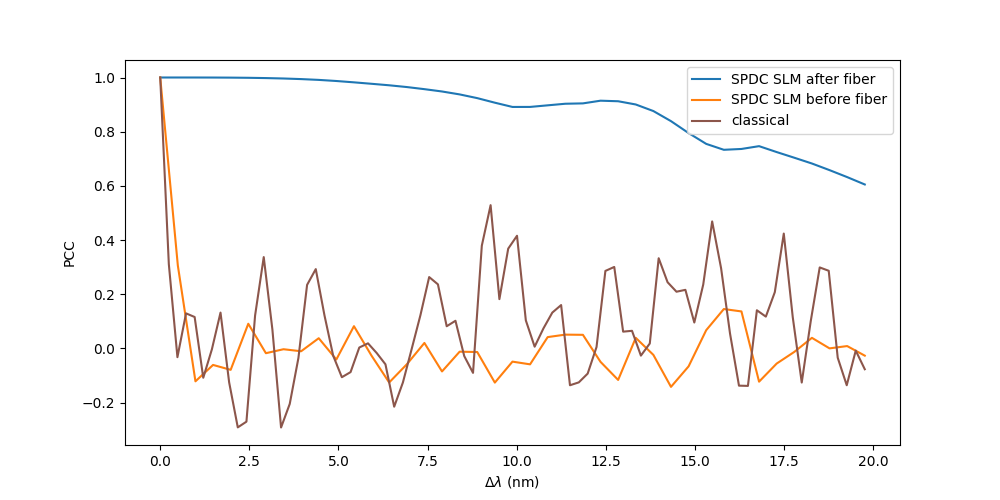

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dl*1e3, pccs, label='SPDC SLM after fiber')
ax.plot(spdc_dl2*1e3, spdc_pccs2, label='SPDC SLM before fiber')
ax.plot(classical_dl*1e3, classical_pccs, label='classical', color='#8c564b')
ax.legend()
ax.set_xlabel(r'$\Delta \lambda$ (nm)')
ax.set_ylabel('PCC')
ax.legend()

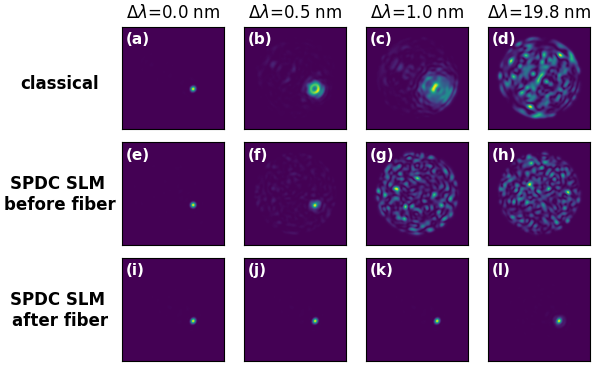

In [77]:
from qdc.misc import colorize
colorize = lambda x: np.abs(x)**2 


is_classical = [0, 2, 4, 80]
is_spdc = [0, 1, 2, 40]
is_SLM2 = [0, 1, 2, 40]
fig, ax = plt.subplots(3, 4, figsize=(6,3.7), constrained_layout=True)
ax[0, 0].set_ylabel('classical', rotation=0, ha='center', fontweight='bold', fontsize=12)
ax[0, 0].yaxis.set_label_coords(-0.6, 0.35, transform=ax[0, 0].transAxes)
ax[1, 0].set_ylabel('SPDC SLM \nbefore fiber', rotation=0, ha='center', fontweight='bold', fontsize=12)
ax[1, 0].yaxis.set_label_coords(-0.6, 0.3, transform=ax[1, 0].transAxes)
ax[2, 0].set_ylabel('SPDC SLM \nafter fiber', rotation=0, ha='center', fontweight='bold', fontsize=12)
ax[2, 0].yaxis.set_label_coords(-0.6, 0.3, transform=ax[2, 0].transAxes)
letters = ['a', 'b', 'c', 'd']
for ax_no, i in enumerate(is_classical):
    data = np.abs(classical_output_fields[i].reshape(npoints, npoints))**2
    data /= data.sum()
    ax[0, ax_no].imshow(data)
    ax[0, ax_no].set_title(f'$\Delta\lambda$={classical_dl[i]*1e3:.1f} nm')
    ax[0, ax_no].set_xticks([]); ax[0, ax_no].set_yticks([])
    ax[0, ax_no].text(0.04, 0.95, f'({letters[ax_no]})', color='white', fontsize=11, fontweight='bold', va='top', ha='left', transform=ax[0, ax_no].transAxes)

letters = ['e', 'f', 'g', 'h']
for ax_no, i in enumerate(is_SLM2):
    data = np.abs(spdc_output_fields2[i].reshape(npoints, npoints))**2
    data /= data.sum()
    ax[1, ax_no].imshow(data)
    # ax[1, ax_no].set_title(f'dl={spdc_dl2[i]*1e3:.1f} nm')
    ax[1, ax_no].set_xticks([]); ax[1, ax_no].set_yticks([])
    ax[1, ax_no].text(0.04, 0.95, f'({letters[ax_no]})', color='white', fontsize=11, fontweight='bold', va='top', ha='left', transform=ax[1, ax_no].transAxes)

letters = ['i', 'j', 'k', 'l']
for ax_no, i in enumerate(is_spdc):
    data = np.abs(output_fields[i].reshape(npoints, npoints))**2
    data /= data.sum()
    ax[2, ax_no].imshow(data)
    # ax[2, ax_no].set_title(f'dl={dl[i]*1e3:.1f} nm')
    ax[2, ax_no].set_xticks([]); ax[2, ax_no].set_yticks([])
    ax[2, ax_no].text(0.04, 0.95, f'({letters[ax_no]})', color='white', fontsize=11, fontweight='bold', va='top', ha='left', transform=ax[2, ax_no].transAxes)

fig.savefig(r'G:\My Drive\Projects\Dispersion Cancelation\Paper\Final Figures\WFS.png')
# ax.imshow(colorize(output_fields[i].reshape(npoints, npoints)))
# ax.imshow(colorize(spdc_output_fields2[i].reshape(npoints, npoints)))
# ax.imshow(colorize(classical_output_fields[i].reshape(npoints, npoints)))
plt.show()

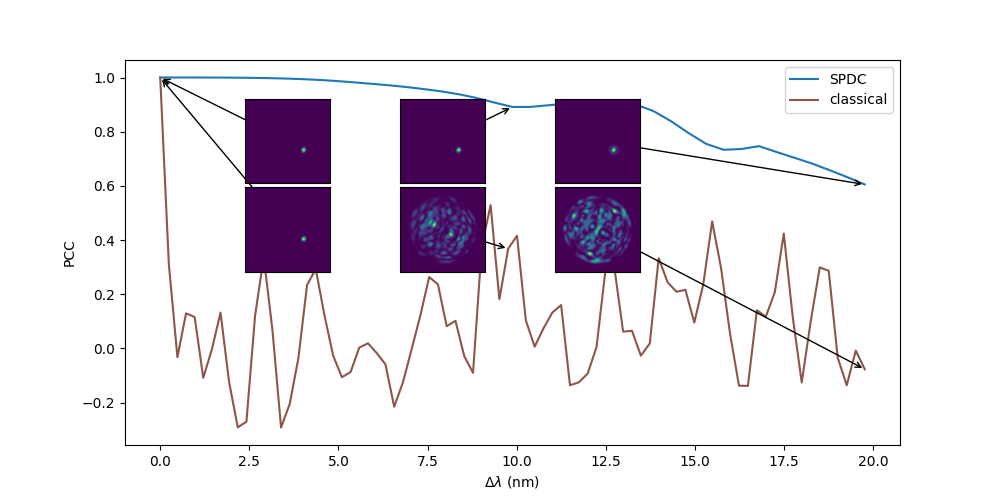

In [ ]:
# Figure with both PCC and insets
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dl*1e3, pccs, label='SPDC')
ax.plot(classical_dl*1e3, classical_pccs, label='classical', color='#8c564b')
ax.legend()
ax.set_xlabel(r'$\Delta \lambda$ (nm)')
ax.set_ylabel('PCC')

# Add insets and arrows at indices 0, 20, 40 for both SPDC and classical
spdc_indices = [0, 20, 40]
classical_indices = [0, 40, 80]
# Layout positions for insets in axes fraction coordinates: [x0, y0, w, h]
# Pair positions (SPDC, Classical) per index for readability and minimal overlap
W, H = 0.22, 0.22
X = [0.1, 0.3, 0.5]
Y = [0.68, 0.45]
inset_positions = {
    0: ([X[0], Y[0], W, H], [X[0], Y[1], W, H]),
    1: ([X[1], Y[0], W, H], [X[1], Y[1], W, H]),
    2: ([X[2], Y[0], W, H], [X[2], Y[1], W, H]),
}

def _reshape_field(field):
    if field.ndim == 1:
        n = int(np.sqrt(field.size))
        return field.reshape(n, n)
    return field

for layout_idx, (spdc_idx, cls_idx) in enumerate(zip(spdc_indices, classical_indices)):
    # SPDC inset
    if spdc_idx < len(dl):
        spdc_field = _reshape_field(output_fields[spdc_idx])
        iax_spdc = inset_axes(ax, width="100%", height="100%", loc='center',
                              bbox_to_anchor=inset_positions[layout_idx][0],
                              bbox_transform=ax.transAxes, borderpad=0)
        iax_spdc.imshow(np.abs(spdc_field)**2, cmap='viridis')
        iax_spdc.set_xticks([]); iax_spdc.set_yticks([])
        ax.annotate('', xy=(dl[spdc_idx]*1e3, pccs[spdc_idx]), xycoords='data',
                    xytext=(0.5, 0.5), textcoords=iax_spdc.transAxes,
                    arrowprops=dict(arrowstyle='->', color='k', lw=1))

    # Classical inset
    if cls_idx < len(classical_dl):
        cls_field = _reshape_field(classical_output_fields[cls_idx])
        iax_cls = inset_axes(ax, width="100%", height="100%", loc='center',
                             bbox_to_anchor=inset_positions[layout_idx][1],
                             bbox_transform=ax.transAxes, borderpad=0)
        iax_cls.imshow(np.abs(cls_field)**2, cmap='viridis')
        iax_cls.set_xticks([]); iax_cls.set_yticks([])
        ax.annotate('', xy=(classical_dl[cls_idx]*1e3, classical_pccs[cls_idx]), xycoords='data',
                    xytext=(0.5, 0.5), textcoords=iax_cls.transAxes,
                    arrowprops=dict(arrowstyle='->', color='k', lw=1))


plt.show(block=False)


In [ ]:
# Make movie 
import matplotlib.animation as animation
from qdc.misc import colorize
import matplotlib as mpl
path = r"C:\Users\owner\AppData\Roaming\Python\Python310\site-packages\imageio_ffmpeg\binaries\ffmpeg-win-x86_64-v7.1.exe"
mpl.rcParams['animation.ffmpeg_path'] = path


def make_movie(output_fields, dl, save_path):
    fps = 4
    fig, ax = plt.subplots(constrained_layout=True)

    def animate(frame_idx):
        ax.clear()

        field = output_fields[frame_idx]
        if field.ndim == 1:
            n = int(np.sqrt(field.size))
            field = field.reshape(n, n)

        ax.imshow(colorize(field), cmap='viridis')

        text = f'$\Delta\\lambda={dl[frame_idx]*1e3:.1f} nm$'
        ax.text(0.5, 0.97, text, color='white', fontsize=18, fontweight='bold',
                va='top', ha='center', transform=ax.transAxes)

        return ax

    anim = animation.FuncAnimation(fig, animate, frames=len(output_fields)-1,
                                    interval=1000//fps, blit=False, repeat=False)

    anim.save(save_path, writer='ffmpeg', fps=fps)
    plt.close(fig)

base_path = r"G:\My Drive\Projects\Dispersion Cancelation\Paper\Movies\Focusing\\"
make_movie(output_fields, dl, f"{base_path}_SPDC_after_fiber.mp4")
make_movie(classical_output_fields, classical_dl, f"{base_path}_classical.mp4")
make_movie(spdc_output_fields2, spdc_dl2, f"{base_path}_SPDC_before_fiber.mp4")

In [80]:
import matplotlib.animation as animation
from qdc.misc import colorize
import matplotlib as mpl
from qdc.misc import show_color_legend_ax
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

path = r"C:\Users\owner\AppData\Roaming\Python\Python310\site-packages\imageio_ffmpeg\binaries\ffmpeg-win-x86_64-v7.1.exe"
mpl.rcParams['animation.ffmpeg_path'] = path
movie_classical_dl = classical_dl[::2]
movie_classical_output_fields = classical_output_fields[::2]


fps = 2
fig, ax = plt.subplots(1, 3, figsize=(9, 3.5))
# keep all axes visible
for a in ax:
    a.set_visible(True)
cax = inset_axes(
    ax[2],
    width="15%",          # legend width
    height="100%",       # EXACTLY match panel height
    loc="lower left",
    bbox_to_anchor=(1.04, 0., 1, 1),   # place just outside the axes
    bbox_transform=ax[2].transAxes,
    borderpad=0,
)
show_color_legend_ax(cax)                                  # your function; shows ticks/labels
cax.set_ylim(0, 1)                                         # full magnitude range
cax.set_aspect('auto')                                     # allow natural aspect


n = int(np.sqrt(output_fields[0].size))

def animate(frame_idx):
    ax[0].clear()
    ax[1].clear()
    ax[2].clear()
    ax[0].set_xticks([]); ax[0].set_yticks([])
    ax[1].set_xticks([]); ax[1].set_yticks([])
    ax[2].set_xticks([]); ax[2].set_yticks([])

    field0 = output_fields[frame_idx]
    field0 = field0.reshape(n, n)
    field1 = spdc_output_fields2[frame_idx]
    field1 = field1.reshape(n, n)
    field2 = movie_classical_output_fields[frame_idx]
    field2 = field2.reshape(n, n)
    ax[0].set_title('classical')
    ax[1].set_title('SPDC SLM before fiber')
    ax[2].set_title('SPDC SLM after fiber')

    ax[0].imshow(colorize(field2), cmap='viridis')
    ax[1].imshow(colorize(field1), cmap='viridis')
    ax[2].imshow(colorize(field0), cmap='viridis')

    text = f'$\Delta\\lambda={movie_classical_dl[frame_idx]*1e3:.1f} nm$'
    ax[0].text(0.5, 0.97, text, color='white', fontsize=14, fontweight='bold',
            va='top', ha='center', transform=ax[0].transAxes)
    text = f'$\Delta\\lambda={spdc_dl2[frame_idx]*1e3:.1f} nm$'
    ax[1].text(0.5, 0.97, text, color='white', fontsize=14, fontweight='bold',
            va='top', ha='center', transform=ax[1].transAxes)
    text = f'$\Delta\\lambda={dl[frame_idx]*1e3:.1f} nm$'
    ax[2].text(0.5, 0.97, text, color='white', fontsize=14, fontweight='bold',
            va='top', ha='center', transform=ax[2].transAxes)

    return ax

anim = animation.FuncAnimation(fig, animate, frames=len(output_fields)-1,
                                interval=1000//fps, blit=False, repeat=False)


path = r"G:\My Drive\Projects\Dispersion Cancelation\Paper\Movies\Focus.mp4"
anim.save(path, writer='ffmpeg', fps=fps)
plt.close(fig)